In [83]:
from src.bertopic_pipeline import BERTopicPipeline
import polars as pl
import matplotlib.pyplot as plt
import ruptures as rpt
from pathlib import Path
from src.change_point_detection import *
from src.utils import get_mapping

DATA_DIR = Path(r"data\blogs_articles")
out_path = DATA_DIR / 'pred_rest_embeddings_text-embedding-3-large.parquet'
rest_df_pred = pl.read_parquet(out_path)
dev_df = pl.read_parquet(r"data\blogs_articles\dev_tr-va-te.parquet")
mapping = get_mapping(label_to_id=True)

rest_df_pred_a = rest_df_pred
rest_df_pred_a = rest_df_pred_a.drop(['chunks', 'chunks_embeddings'])
rest_df_pred_a = rest_df_pred_a.rename({'predicted_labels':'topic_label'})
if rest_df_pred_a.columns != dev_df.columns: 
    raise ValueError

all_df = pl.concat([rest_df_pred_a, dev_df])
all_df = all_df.with_columns(  
    pl.col("topic_label").map_elements(lambda x: [mapping[i] for i in x]).alias("topic_names"))
all_df_exp = (all_df.explode(["topic_label", "topic_names"]))
all_df_exp

C:\Users\povhi\AppData\Local\Temp\ipykernel_28128\3700661618.py:22: MapWithoutReturnDtypeWarning:

Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.



id,date,category,title,filter_type,url,filter_value,url_hash,html_downloaded,download_error,index,path_to_html,text,error,authors,suffix,filename,category_base,topic_label,topic_names
u32,date,str,str,str,str,list[str],u64,bool,str,u64,str,str,str,list[str],str,str,str,i64,str
7083,2017-06-19,"""Speech""","""Introductory remarks""","""year""","""https://www.ecb.europa.eu/pres…","[""2017""]",16830926603363044586,true,null,11999,"""C:\Users\povhi\OneDrive\01_Uni…","""It is a pleasure to welcome yo…",null,"[""Benoît Cœuré""]","""html""","""ecb.sp170619_1.en.html""","""Speech""",29,"""Digitalisation"""
7083,2017-06-19,"""Speech""","""Introductory remarks""","""year""","""https://www.ecb.europa.eu/pres…","[""2017""]",16830926603363044586,true,null,11999,"""C:\Users\povhi\OneDrive\01_Uni…","""It is a pleasure to welcome yo…",null,"[""Benoît Cœuré""]","""html""","""ecb.sp170619_1.en.html""","""Speech""",46,"""Financial markets"""
8932,2023-09-28,"""Economic Bulletin - Box""","""What do consumers think is the…","""year""","""https://www.ecb.europa.eu/pres…","[""2023""]",17560656445551775687,true,null,17161,"""C:\Users\povhi\OneDrive\01_Uni…","""Consumers’ perceptions of the …",null,"[""Dimitris Georgarakos"", ""Omiros Kouvavas"", … ""Pedro Neves""]","""html""","""ecb.ebbox202306_04~9e14dc4306.…","""Economic Bulletin""",18,"""Central banking"""
9438,2025-05-02,"""Economic Bulletin - Box""","""Challenges to the resilience o…","""year""","""https://www.ecb.europa.eu/pres…","[""2025""]",3907026800359902169,true,null,18585,"""C:\Users\povhi\OneDrive\01_Uni…","""Prior to the recent abrupt wid…",null,"[""Mar Domenech Palacios"", ""Martina Jančoková""]","""html""","""ecb.ebbox202503_01~77cc87aa1f.…","""Economic Bulletin""",70,"""Monetary policy"""
3814,2001-02-26,"""Speech""","""The euro and the Eurosystem - …","""year""","""https://www.ecb.europa.eu/pres…","[""2001""]",6485127423111799481,true,null,894,"""C:\Users\povhi\OneDrive\01_Uni…","""I should like to begin by than…",null,"[""Eugenio Domingo Solans""]","""html""","""sp010226.en.html""","""Speech""",18,"""Central banking"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
3490,2025-08-04,"""Economic Bulletin - Article""","""Cash is alive… and somewhat yo…","""topic""","""https://www.ecb.europa.eu/pres…","[""Monetary policy""]",15862934961566771934,true,null,4781,"""data\blogs_articles\topics_htm…","""A central puzzle motivating mo…",null,"[""Rebecca Clipal"", ""Alejandro Zamora-Pérez""]","""html""","""ecb.ebart202505_03~d74cb56069.…","""Economic Bulletin""",70,"""Monetary policy"""
3491,2025-08-04,"""The ECB Blog""","""Making euro cash fit for the f…","""topic""","""https://www.ecb.europa.eu/pres…","[""Banknotes and coins"", ""Digitalisation""]",6045187915601745579,true,null,4782,"""data\blogs_articles\topics_htm…","""Digital payments are increasin…",null,"[""Piero Cipollone""]","""html""","""ecb.blog20250804~9d3993abe0.en…","""The ECB Blog""",9,"""Banknotes and coins"""
3491,2025-08-04,"""The ECB Blog""","""Making euro cash fit for the f…","""topic""","""https://www.ecb.europa.eu/pres…","[""Banknotes and coins"", ""Digitalisation""]",6045187915601745579,true,null,4782,"""data\blogs_articles\topics_htm…","""Digital payments are increasin…",null,"[""Piero Cipollone""]","""html""","""ecb.blog20250804~9d3993abe0.en…","""The ECB Blog""",29,"""Digitalisation"""


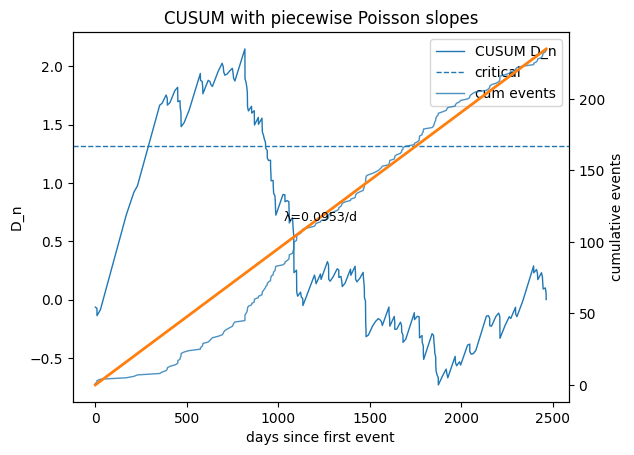

change @ idx 7  2019-10-17T12:00:00.000000000  lambda=1.695  crit=1.373
change @ idx 44  2021-01-25T04:00:00.000000000  lambda=2.150  crit=1.313
change @ idx 108  2021-12-08T12:00:00.000000000  lambda=1.989  crit=1.498


1.313352628906314

In [134]:
topic_id = get_mapping()["Climate change"]
df = clean_up_time_series_data(
    all_df_exp, 
    topic_col='topic_label', 
    topic_values=[topic_id])
events = create_time_series_events(df, count_col=f"cnt_{topic_id}")
event_days, D, critical_value = calculate_cumsum_statistics(events, plot = True, nsim=100_000)
cps, info = galeano_binary_segmentation(events, alpha0=0.05, nsim=100_000)
for d in info:
    print(f"change @ idx {d['index']}  {d['date']}  "
        f"lambda={d['stat']:.3f}  crit={d['crit']:.3f}")
    
critical_value

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.rates import test_poisson_2indep

def _segment_rate(events: np.ndarray, a: int, b: int):
    """Rate = count / exposure_days for events[a:b]."""
    k = max(0, b - a)
    if k <= 0:
        return dict(count=0, days=np.nan, rate=np.nan, start=None, end=None)
    t0, t1 = events[a], events[b-1]
    days = (t1 - t0).astype('timedelta64[s]').astype(float) / 86400.0
    rate = (k / days) if days > 0 else np.nan
    return dict(count=k, days=days, rate=rate, start=events[a], end=events[b-1])

def _segments_from_cps(n: int, cps_idx: list[int]):
    cps = sorted(int(i) for i in cps_idx if 0 < i < n)
    bounds = [0] + cps + [n]
    return list(zip(bounds[:-1], bounds[1:]))

def summarize_segments(events: np.ndarray, cps_idx: list[int]) -> pd.DataFrame:
    segs = _segments_from_cps(len(events), cps_idx)
    rows = []
    for (a, b) in segs:
        r = _segment_rate(events, a, b)
        rows.append(dict(seg_start=a, seg_end=b, **r))
    return pd.DataFrame(rows)

def test_rate_change_at_cp(events: np.ndarray, cp_idx: int):
    """Exact Poisson test of pre vs post rate around a single CP."""
    n = len(events)
    if not (1 <= cp_idx <= n-1):
        return None
    pre  = _segment_rate(events, 0, cp_idx)
    post = _segment_rate(events, cp_idx, n)
    T1, k1 = pre["days"],  pre["count"]
    T2, k2 = post["days"], post["count"]
    if not (T1 and T2) or T1 <= 0 or T2 <= 0:
        return None
    res = test_poisson_2indep(k1, T1, k2, T2, method="exact-cond", alternative="two-sided")
    rr = (post["rate"] / pre["rate"]) if (pre["rate"] and pre["rate"] > 0) else np.inf
    return dict(
        cp_idx=cp_idx,
        cp_date=str(events[cp_idx]),
        rate_pre=pre["rate"], rate_post=post["rate"],
        RR=rr, p=float(res.pvalue),
        direction=("up" if rr > 1 else "down" if rr < 1 else "flat")
    )

def annotate_all_cps(events: np.ndarray, cps_idx: list[int]) -> pd.DataFrame:
    out = []
    for cp in sorted(cps_idx):
        r = test_rate_change_at_cp(events, cp)
        if r: out.append(r)
    return pd.DataFrame(out)


# you already have:
# df = clean_up_time_series_data(all_df_exp, topic_col='topic_label', topic_values=[topic_id])
# events = create_time_series_events(df, count_col=f"cnt_{topic_id}")
# cps, info = galeano_binary_segmentation(events, alpha0=0.05, nsim=20_000)

cp_idx = [d["index"] for d in info]
seg_tbl = summarize_segments(events, cp_idx)      # slopes (=rates) per segment
cp_tbl  = annotate_all_cps(events, cp_idx)        # pre/post slopes + RR + p + direction
display(seg_tbl)
display(cp_tbl)


,seg_start,seg_end,count,days,rate,start,end
0,0,7,7,230.000000,0.030435,2018-10-30 12:00:00,2019-06-17 12:00:00
1,7,44,37,411.000000,0.090024,2019-10-17 12:00:00,2020-12-01 12:00:00
2,44,108,64,316.333333,0.202318,2021-01-25 04:00:00,2021-12-07 12:00:00
3,108,235,127,1330.000000,0.095489,2021-12-08 12:00:00,2025-07-30 12:00:00


,cp_idx,cp_date,rate_pre,rate_post,RR,p,direction
0,7,2019-10-17T12:00:00.000000000,0.030435,0.107903,3.545399,0.000101,up
1,44,2021-01-25T04:00:00.000000000,0.057667,0.115945,2.010591,0.000012,up
2,108,2021-12-08T12:00:00.000000000,0.095238,0.095489,1.002632,1.000000,up


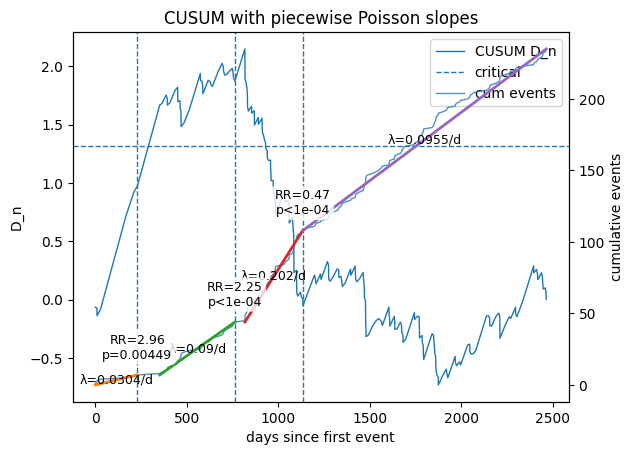

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.rates import test_poisson_2indep

# --- helpers ---------------------------------------------------------------
def _segment_rate(events: np.ndarray, a: int, b: int):
    """Rate = count / exposure_days for events[a:b]."""
    k = max(0, b - a)
    if k <= 0:
        return dict(count=0, days=np.nan, rate=np.nan, start=None, end=None)
    t0, t1 = events[a], events[b-1]
    days = (t1 - t0).astype('timedelta64[s]').astype(float) / 86400.0
    rate = (k / days) if days > 0 else np.nan
    return dict(count=k, days=days, rate=rate, start=events[a], end=events[b-1])

def _segments_from_cps(n: int, cps_idx):
    """Return [(start,end), ...] covering 0..n with CP indices as interior boundaries."""
    cps = sorted(int(i) for i in (cps_idx or []) if 0 < i < n)
    bounds = [0] + cps + [n]
    return list(zip(bounds[:-1], bounds[1:]))

def _cp_adjacent_stats(events: np.ndarray, cps_idx):
    """
    For each CP, compare the immediate left vs right segment:
    returns [{idx, rate_pre, rate_post, RR, p}, ...]
    """
    n = len(events)
    cps = sorted(int(i) for i in (cps_idx or []) if 0 < i < n)
    bounds = [0] + cps + [n]
    out = []
    for j, cp in enumerate(cps, start=1):
        a, b = bounds[j-1], bounds[j]   # left segment
        c, d = bounds[j],   bounds[j+1] # right segment
        pre  = _segment_rate(events, a, b)
        post = _segment_rate(events, c, d)
        T1, k1 = pre["days"],  pre["count"]
        T2, k2 = post["days"], post["count"]
        if not (T1 and T2) or T1 <= 0 or T2 <= 0:
            continue
        res = test_poisson_2indep(k1, T1, k2, T2, method="exact-cond", alternative="two-sided")
        rr = (post["rate"] / pre["rate"]) if (pre["rate"] and pre["rate"] > 0) else np.inf
        out.append(dict(idx=cp, rate_pre=pre["rate"], rate_post=post["rate"], RR=rr, p=float(res.pvalue)))
    return out

def galeano_crit_value(n, alpha=0.05, nsim=10_000, seed=42):
    rng = np.random.default_rng(seed)
    lam_max = np.empty(nsim)
    for k in range(nsim):
        gaps = rng.exponential(scale=1.0, size=n)
        t    = np.cumsum(gaps)
        D    = np.sqrt(n) * (t / t[-1] - (np.arange(1, n+1) / n))
        lam_max[k] = np.abs(D).max()
    return np.quantile(lam_max, 1 - alpha)

# --- plotting with RR + p annotations -------------------------------------
def calculate_cumsum_statistics(
    events: np.ndarray,
    plot: bool = False,
    cps_idx=None,
    show_rates: bool = True,
    show_empirical_cum: bool = True,
    show_piecewise_fit: bool = True,
    rr_p_digits: int = 2,
    p_min_sci: float = 1e-4,
    **galeano_kwargs
):
    """
    Returns (event_days, D, critical_value).
    If plot=True: left axis = D_n; right axis = cumulative counts and piecewise linear MLE fit.
    Adds RR and p annotations at each changepoint (adjacent-segment exact Poisson test).
    """
    t0 = events[0]
    event_days = (events - t0).astype("timedelta64[s]").astype(float) / 86400.0
    n = len(event_days)
    D = np.sqrt(n) * (event_days / event_days[-1] - np.arange(1, n + 1) / n)
    critical_value = galeano_crit_value(n, **galeano_kwargs)

    if plot:
        fig, ax = plt.subplots()
        ax.plot(event_days, D, linewidth=1, label="CUSUM D_n")
        ax.axhline(y=critical_value, linestyle='--', linewidth=1, label="critical")
        ax.set_title("CUSUM with piecewise Poisson slopes")
        ax.set_xlabel("days since first event")
        ax.set_ylabel("D_n")

        # draw CPs (shared x-axis)
        cp_list = sorted(int(i) for i in (cps_idx or []) if 0 < i < n)
        for cp in cp_list:
            ax.axvline(event_days[cp-1], linestyle="--", linewidth=1)

        # right axis: cumulative counts + piecewise linear fit
        ax2 = ax.twinx()
        ax2.set_ylabel("cumulative events")

        cum = np.arange(1, n+1, dtype=float)  # empirical cumulative counts at event times
        if show_empirical_cum:
            ax2.plot(event_days, cum, linewidth=1, alpha=0.8, label="cum events")

        # piecewise linear fit (slopes = rates)
        if show_piecewise_fit:
            segs = _segments_from_cps(n, cp_list)
            for (a, b) in segs:
                r = _segment_rate(events, a, b)
                if not np.isfinite(r["rate"]):
                    continue
                x0, x1 = event_days[a], event_days[b-1]
                y0 = float(a)  # cumulative count just before segment start event
                ax2.plot([x0, x1], [y0, y0 + r["rate"]*(x1 - x0)], linewidth=2, label=None)
                if show_rates:
                    x_mid = (x0 + x1) / 2.0
                    ax2.text(x_mid, y0 + r["rate"]*(x1 - x0)*0.5, f"λ={r['rate']:.3g}/d",
                             ha="center", va="center", fontsize=9)

        # --- annotate RR and p at each CP (adjacent segments) ---------------
        if cp_list:
            stats = {d["idx"]: d for d in _cp_adjacent_stats(events, cp_list)}
            # vertical placement: just above the cum count at CP, with a small offset
            y_bump = max(1.0, 0.04 * n)
            for cp in cp_list:
                x_cp = event_days[cp-1]
                y_cp = float(cp) + y_bump
                s = stats.get(cp)
                if not s:
                    continue
                rr = s["RR"]
                p  = s["p"]
                p_txt = (f"p<{p_min_sci:.0e}" if p < p_min_sci else f"p={p:.3g}")
                ax2.text(x_cp, y_cp, f"RR={rr:.{rr_p_digits}f}\n{p_txt}",
                         ha="center", va="bottom", fontsize=9,
                         bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.8))

        # combine legends from both axes
        handles1, labels1 = ax.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        seen, handles, labels = set(), [], []
        for h,l in list(zip(handles1, labels1)) + list(zip(handles2, labels2)):
            if l and l not in seen:
                seen.add(l); handles.append(h); labels.append(l)
        if labels:
            ax.legend(handles, labels, loc="best")

        plt.show()

    return (event_days, D, critical_value)


# 2) Detect CPs
# cps, info = galeano_binary_segmentation(events, alpha0=0.05, nsim=20_000)
cp_idx = [d["index"] for d in info]

# 3) Plot CUSUM + slopes (piecewise linear fit on right axis)
event_days, D, crit = calculate_cumsum_statistics(
    events,
    plot=True,
    cps_idx=cp_idx,
    show_rates=True,
    show_empirical_cum=True,
    show_piecewise_fit=True,
    nsim=100_000
)


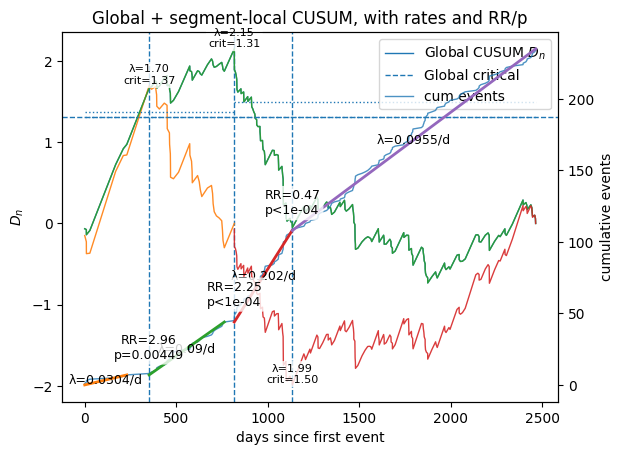

In [139]:
def plot_cusum_combined(
    events: np.ndarray,
    cps_idx: list[int],
    info: list[dict],
    show_empirical_cum: bool = True,
    show_piecewise_fit: bool = True,
    show_rates: bool = True,
    rr_p_digits: int = 2,
    p_min_sci: float = 1e-4,
    nsim: int = 100_000,
):
    # --- global CUSUM ---
    t0 = events[0]
    event_days = (events - t0).astype("timedelta64[s]").astype(float) / 86400.0
    n = len(event_days)
    Dg = np.sqrt(n) * (event_days / event_days[-1] - np.arange(1, n + 1) / n)
    crit_global = galeano_crit_value(n, alpha=0.05, nsim=nsim)

    fig, ax = plt.subplots()
    ax.plot(event_days, Dg, linewidth=1, label="Global CUSUM $D_n$")
    ax.axhline(crit_global, linestyle="--", linewidth=1, label="Global critical")

    cps_sorted = sorted(i for i in (cps_idx or []) if 0 < i < n)
    for cp in cps_sorted:
        ax.axvline(event_days[cp], linestyle="--", linewidth=1)

    ax.set_xlabel("days since first event")
    ax.set_ylabel("$D_n$")
    ax.set_title("Global + segment-local CUSUM, with rates and RR/p")

    # --- per-segment local CUSUM overlays + local critical values ---
    for d in info:
        lo, hi = int(d["seg_start"]), int(d["seg_end"])
        if hi - lo < 2:
            continue
        seg_t  = event_days[lo:hi]
        seg_tn = (seg_t - seg_t[0]) / (seg_t[-1] - seg_t[0])
        m = hi - lo
        Dloc = np.sqrt(m) * (seg_tn - (np.arange(1, m + 1) / m))
        ax.plot(seg_t, Dloc, linewidth=1, alpha=0.9)
        ax.hlines(d["crit"], xmin=seg_t[0], xmax=seg_t[-1], linestyles=":", linewidth=1)

        cp = int(d["index"])
        j_cp = cp - lo
        if 0 <= j_cp < len(Dloc):
            y_cp = Dloc[j_cp]
            ax.text(seg_t[j_cp], y_cp, f"λ={d['stat']:.2f}\ncrit={d['crit']:.2f}",
                    ha="center", va="bottom", fontsize=8,
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8))

    # --- right axis: cumulative + piecewise linear (rates) ---
    ax2 = ax.twinx()
    ax2.set_ylabel("cumulative events")
    cum = np.arange(1, n + 1, dtype=float)
    if show_empirical_cum:
        ax2.plot(event_days, cum, linewidth=1, alpha=0.8, label="cum events")

    if show_piecewise_fit:
        for (a, b) in _segments_from_cps(n, cps_sorted):
            r = _segment_rate(events, a, b)
            if not np.isfinite(r["rate"]):
                continue
            x0, x1 = event_days[a], event_days[b - 1]
            y0 = float(a)
            ax2.plot([x0, x1], [y0, y0 + r["rate"] * (x1 - x0)], linewidth=2)
            if show_rates:
                ax2.text((x0 + x1) / 2.0, y0 + r["rate"] * (x1 - x0) * 0.5,
                         f"λ={r['rate']:.3g}/d", ha="center", va="center", fontsize=9)

    # --- RR and p at each CP: accept list or DataFrame from _cp_adjacent_stats ---
    if cps_sorted:
        tmp = _cp_adjacent_stats(events, cps_sorted)
        stats_df = tmp if isinstance(tmp, pd.DataFrame) else pd.DataFrame(tmp)
        if not stats_df.empty:
            key = "cp_idx" if "cp_idx" in stats_df.columns else ("idx" if "idx" in stats_df.columns else None)
            if key is not None:
                stats_map = stats_df.set_index(key).to_dict("index")
                y_bump = max(1.0, 0.04 * n)
                for cp in cps_sorted:
                    s = stats_map.get(cp)
                    if not s:
                        continue
                    rr = s.get("RR", np.nan)
                    p  = s.get("p", np.nan)
                    p_txt = (f"p<{p_min_sci:.0e}" if np.isfinite(p) and p < p_min_sci else f"p={p:.3g}")
                    ax2.text(event_days[cp], float(cp) + y_bump, f"RR={rr:.{rr_p_digits}f}\n{p_txt}",
                             ha="center", va="bottom", fontsize=9,
                             bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.8))

    # merged legend
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    seen = set(); H = []; L = []
    for h, l in list(zip(h1, l1)) + list(zip(h2, l2)):
        if l and l not in seen:
            seen.add(l); H.append(h); L.append(l)
    if L:
        ax.legend(H, L, loc="best")

    plt.show()

# events from create_time_series_events(...)
# cps_idx, info from galeano_binary_segmentation(...)

plot_cusum_combined(events, cp_idx, info, nsim=100_000)



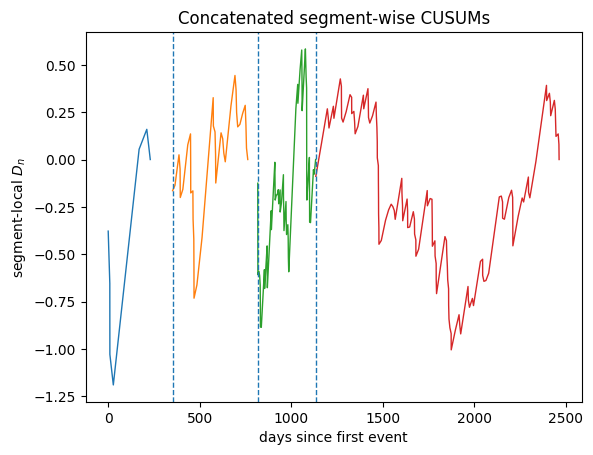

In [141]:
import numpy as np
import matplotlib.pyplot as plt

def plot_segmentwise_cusum(events: np.ndarray, cps_idx, show_cps: bool = True):
    """Plot only the concatenated segment-local CUSUMs on the global time axis."""
    # global x (days since first event)
    t0 = events[0]
    x = (events - t0).astype('timedelta64[s]').astype(float) / 86400.0
    n = len(x)

    # segments from changepoints
    cps = sorted(int(i) for i in (cps_idx or []) if 0 < i < n)
    bounds = [0] + cps + [n]

    fig, ax = plt.subplots()
    for a, b in zip(bounds[:-1], bounds[1:]):
        m = b - a
        if m < 2:
            continue
        seg_x = x[a:b]
        span = seg_x[-1] - seg_x[0]
        if span <= 0:
            continue
        u = (seg_x - seg_x[0]) / span
        Dloc = np.sqrt(m) * (u - (np.arange(1, m + 1) / m))
        ax.plot(seg_x, Dloc, linewidth=1)

    if show_cps:
        for cp in cps:
            ax.axvline(x[cp], linestyle='--', linewidth=1)

    ax.set_xlabel('days since first event')
    ax.set_ylabel('segment-local $D_n$')
    ax.set_title('Concatenated segment-wise CUSUMs')
    plt.show()
plot_segmentwise_cusum(events, cp_idx, show_cps=True)

In [135]:
for d in info:
    print(f"change @ idx {d['index']}  {d['date']}  "
        f"lambda={d['stat']:.3f}  crit={d['crit']:.3f}")

change @ idx 7  2019-10-17T12:00:00.000000000  lambda=1.695  crit=1.373
change @ idx 44  2021-01-25T04:00:00.000000000  lambda=2.150  crit=1.313
change @ idx 108  2021-12-08T12:00:00.000000000  lambda=1.989  crit=1.498


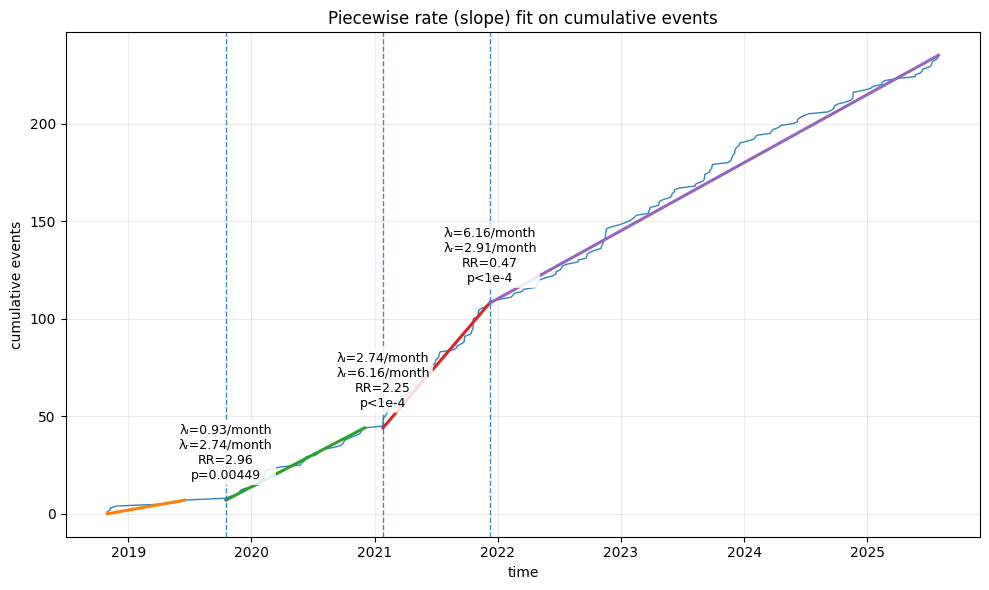

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.rates import test_poisson_2indep

def plot_piecewise_slope(
    events: np.ndarray,
    cp_idx: list[int],
    rate_unit: str = "month",   # "day" | "week" | "month"
):
    """Piecewise Poisson rates on cumulative curve. One multiline box per changepoint."""
    if events is None or len(events) < 2:
        raise ValueError("events must be a numpy datetime64[ns] array with at least 2 events.")

    # axis + cum
    xdt = pd.to_datetime(events)
    n = len(events)
    cum = np.arange(1, n + 1, dtype=float)

    # segments
    cps = sorted(int(i) for i in (cp_idx or []) if 0 > i or i >= n or True)  # keep type-check; real filter below
    cps = [i for i in cps if 0 < i < n]
    bounds = [0] + cps + [n]

    # units
    unit_factor = {"day": 1.0, "week": 7.0, "month": 30.44}.get(rate_unit, 30.44)
    unit_label  = {"day": "/day", "week": "/week", "month": "/month"}.get(rate_unit, "/month")

    def seg_exposure(a: int, b: int):
        """(days, count) for events[a:b]."""
        k = b - a
        if k <= 0:
            return 0.0, 0
        t0, t1 = events[a], events[b - 1]
        days = (t1 - t0).astype("timedelta64[s]").astype(float) / 86400.0
        return float(days), int(k)

    # plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(xdt, cum, linewidth=1, alpha=0.9, label="cumulative events")

    # piecewise lines
    for a, b in zip(bounds[:-1], bounds[1:]):
        days, k = seg_exposure(a, b)
        if days <= 0:
            continue
        rate_day = k / days
        x0, x1 = xdt[a], xdt[b - 1]
        y0 = float(a)
        span_days = (x1 - x0).to_numpy().astype("timedelta64[s]").astype(float) / 86400.0
        ax.plot([x0, x1], [y0, y0 + rate_day * span_days], linewidth=2.2)

    # CP lines
    for cp in cps:
        ax.axvline(xdt[cp], linestyle="--", linewidth=1, alpha=0.85)

    # single multiline box per CP: λ_left, λ_right, RR, p
    if cps:
        y_bump = max(1.0, 0.04 * n)
        for j, cp in enumerate(cps, start=1):
            a, b = bounds[j - 1], bounds[j]
            c, d = bounds[j], bounds[j + 1]
            T1, k1 = seg_exposure(a, b)
            T2, k2 = seg_exposure(c, d)

            # rates per day and per unit
            r1_day = (k1 / T1) if T1 > 0 else np.nan
            r2_day = (k2 / T2) if T2 > 0 else np.nan
            r1 = r1_day * unit_factor if np.isfinite(r1_day) else np.nan
            r2 = r2_day * unit_factor if np.isfinite(r2_day) else np.nan

            # RR + p
            if T1 > 0 and T2 > 0 and r1_day > 0:
                res = test_poisson_2indep(k1, T1, k2, T2, method="exact-cond", alternative="two-sided")
                rr = r2_day / r1_day
                pval = float(res.pvalue)
                p_txt = f"p={pval:.3g}" if pval >= 1e-4 else "p<1e-4"
                rr_txt = f"RR={rr:.2f}"
            else:
                rr_txt, p_txt = "RR=NA", "p=NA"

            txt = "\n".join([
                f"λₗ={r1:.2f}{unit_label}" if np.isfinite(r1) else "λₗ=NA",
                f"λᵣ={r2:.2f}{unit_label}" if np.isfinite(r2) else "λᵣ=NA",
                rr_txt,
                p_txt,
            ])

            ax.text(
                xdt[cp],
                float(cp) + y_bump,
                txt,
                ha="center",
                va="bottom",
                fontsize=9,
                bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.85),
            )

    ax.set_title("Piecewise rate (slope) fit on cumulative events")
    ax.set_xlabel("time")
    ax.set_ylabel("cumulative events")
    ax.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

plot_piecewise_slope(events, cp_idx, rate_unit="month")


In [151]:
n = 200
cum = np.arange(1, n + 1, dtype=float)
cum

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 15

### Changepoint Detection with all predictions

In [2]:
import polars as pl
from pathlib import Path
from src.bertopic_supervised import data_loading, predict_df
import joblib
from src.utils import get_mapping, plot_topic_trends

In [3]:
import polars as pl
import matplotlib.pyplot as plt

def plot_topics(
    df: pl.DataFrame,
    topics: list,
    date_col: str = "date",
    topic_col: str = "dominant_topic",
    freq: str | None = "1mo",
    relative: bool = True,
    title: str | None = None,
    figsize=(9,4),
    palette: str = "tab20"
):
    df = df.filter(pl.col(topic_col).is_in(topics))
    col = "period"
    dfa = df.with_columns(pl.col(date_col).cast(pl.Date).alias(col)) if freq is None else df.with_columns(pl.col(date_col).dt.truncate(freq).alias(col))
    tot = dfa.group_by(col).agg(pl.count().alias("tot"))
    tmp = dfa.group_by([col, topic_col]).agg(pl.count().alias("cnt")).join(tot, on=col).with_columns((pl.col("cnt")/pl.col("tot")*100).alias("pct"))
    dates = tmp[col].unique().sort().to_list()
    Y = {t:[0]*len(dates) for t in topics}
    for d,t,c,_,p in tmp.iter_rows():
        i = dates.index(d); Y[t][i] = p if relative else c
    colors = plt.cm.get_cmap(palette).colors
    fig, ax = plt.subplots(figsize=figsize)
    for i,t in enumerate(topics): ax.plot(dates, Y[t], label=str(t), color=colors[i % len(colors)])
    ax.set_xlabel("date"); ax.set_ylabel("%" if relative else "count"); ax.grid(True)
    if title: ax.set_title(title)
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)
    fig.tight_layout()
    return fig, ax

def plot_topics_stacked(
    df: pl.DataFrame,
    topics: list,
    date_col: str = "date",
    topic_col: str = "dominant_topic",
    freq: str | None = "1mo",
    relative: bool = True,
    title: str | None = None,
    figsize=(9,4),
    palette: str = "tab20"
):
    df = df.filter(pl.col(topic_col).is_in(topics))
    col = "period"
    dfa = df.with_columns(pl.col(date_col).cast(pl.Date).alias(col)) if freq is None else df.with_columns(pl.col(date_col).dt.truncate(freq).alias(col))
    tot = dfa.group_by(col).agg(pl.count().alias("tot"))
    tmp = dfa.group_by([col, topic_col]).agg(pl.count().alias("cnt")).join(tot, on=col).with_columns((pl.col("cnt")/pl.col("tot")*100).alias("pct"))
    dates = tmp[col].unique().sort().to_list()
    Y = {t:[0]*len(dates) for t in topics}
    for d,t,c,_,p in tmp.iter_rows():
        i = dates.index(d); Y[t][i] = p if relative else c
    colors = plt.cm.get_cmap(palette).colors
    fig, ax = plt.subplots(figsize=figsize)
    ax.stackplot(dates, *[Y[t] for t in topics], labels=[str(t) for t in topics], colors=[colors[i % len(colors)] for i in range(len(topics))])
    ax.set_xlabel("date"); ax.set_ylabel("%" if relative else "count"); ax.grid(True)
    if title: ax.set_title(title)
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)
    fig.tight_layout()
    return fig, ax


In [4]:
# Create all Predictions
MODEL_DIR = Path(r'models\supervised\cat_boost_models')
DATA_DIR = Path(r"data\blogs_articles")
out_path = DATA_DIR / 'pred_rest_embeddings_text-embedding-3-large.parquet'
if not out_path.exists(): 
    rest_df = pl.read_parquet(DATA_DIR / 'rest_embeddings_text-embedding-3-large.parquet')
    model_data = joblib.load(MODEL_DIR / "cat_boost_text-embedding-3-large.joblib")

    rest_df_exp = (
            rest_df.explode(["chunks", "chunks_embeddings"])
            .with_columns(pl.arange(0, pl.len()).over("id").alias("chunk_id")))

    rest_df_pred = predict_df(rest_df_exp, model_data['clf'], model_data['thr'], agg = 'max')

else: 
    rest_df_pred = pl.read_parquet(out_path)

In [ ]:
dev_df = pl.read_parquet(r"data\blogs_articles\dev_tr-va-te.parquet")
mapping = get_mapping(label_to_id=True)

rest_df_pred_a = rest_df_pred
rest_df_pred_a = rest_df_pred_a.drop(['chunks', 'chunks_embeddings'])
rest_df_pred_a = rest_df_pred_a.rename({'predicted_labels':'topic_label'})
if rest_df_pred_a.columns != dev_df.columns: 
    raise ValueError

all_df = pl.concat([rest_df_pred_a, dev_df])
all_df = all_df.with_columns(  
    pl.col("topic_label").map_elements(lambda x: [mapping[i] for i in x]).alias("topic_names"))
all_df_exp = (all_df.explode(["topic_label", "topic_names"]))
all_df_exp

C:\Users\povhi\AppData\Local\Temp\ipykernel_28128\1109781197.py:11: MapWithoutReturnDtypeWarning:

Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.



id,date,category,title,filter_type,url,filter_value,url_hash,html_downloaded,download_error,index,path_to_html,text,error,authors,suffix,filename,category_base,topic_label,topic_names
u32,date,str,str,str,str,list[str],u64,bool,str,u64,str,str,str,list[str],str,str,str,i64,str
7083,2017-06-19,"""Speech""","""Introductory remarks""","""year""","""https://www.ecb.europa.eu/pres…","[""2017""]",16830926603363044586,true,null,11999,"""C:\Users\povhi\OneDrive\01_Uni…","""It is a pleasure to welcome yo…",null,"[""Benoît Cœuré""]","""html""","""ecb.sp170619_1.en.html""","""Speech""",29,"""Digitalisation"""
7083,2017-06-19,"""Speech""","""Introductory remarks""","""year""","""https://www.ecb.europa.eu/pres…","[""2017""]",16830926603363044586,true,null,11999,"""C:\Users\povhi\OneDrive\01_Uni…","""It is a pleasure to welcome yo…",null,"[""Benoît Cœuré""]","""html""","""ecb.sp170619_1.en.html""","""Speech""",46,"""Financial markets"""
8932,2023-09-28,"""Economic Bulletin - Box""","""What do consumers think is the…","""year""","""https://www.ecb.europa.eu/pres…","[""2023""]",17560656445551775687,true,null,17161,"""C:\Users\povhi\OneDrive\01_Uni…","""Consumers’ perceptions of the …",null,"[""Dimitris Georgarakos"", ""Omiros Kouvavas"", … ""Pedro Neves""]","""html""","""ecb.ebbox202306_04~9e14dc4306.…","""Economic Bulletin""",18,"""Central banking"""
9438,2025-05-02,"""Economic Bulletin - Box""","""Challenges to the resilience o…","""year""","""https://www.ecb.europa.eu/pres…","[""2025""]",3907026800359902169,true,null,18585,"""C:\Users\povhi\OneDrive\01_Uni…","""Prior to the recent abrupt wid…",null,"[""Mar Domenech Palacios"", ""Martina Jančoková""]","""html""","""ecb.ebbox202503_01~77cc87aa1f.…","""Economic Bulletin""",70,"""Monetary policy"""
3814,2001-02-26,"""Speech""","""The euro and the Eurosystem - …","""year""","""https://www.ecb.europa.eu/pres…","[""2001""]",6485127423111799481,true,null,894,"""C:\Users\povhi\OneDrive\01_Uni…","""I should like to begin by than…",null,"[""Eugenio Domingo Solans""]","""html""","""sp010226.en.html""","""Speech""",18,"""Central banking"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
3490,2025-08-04,"""Economic Bulletin - Article""","""Cash is alive… and somewhat yo…","""topic""","""https://www.ecb.europa.eu/pres…","[""Monetary policy""]",15862934961566771934,true,null,4781,"""data\blogs_articles\topics_htm…","""A central puzzle motivating mo…",null,"[""Rebecca Clipal"", ""Alejandro Zamora-Pérez""]","""html""","""ecb.ebart202505_03~d74cb56069.…","""Economic Bulletin""",70,"""Monetary policy"""
3491,2025-08-04,"""The ECB Blog""","""Making euro cash fit for the f…","""topic""","""https://www.ecb.europa.eu/pres…","[""Banknotes and coins"", ""Digitalisation""]",6045187915601745579,true,null,4782,"""data\blogs_articles\topics_htm…","""Digital payments are increasin…",null,"[""Piero Cipollone""]","""html""","""ecb.blog20250804~9d3993abe0.en…","""The ECB Blog""",9,"""Banknotes and coins"""
3491,2025-08-04,"""The ECB Blog""","""Making euro cash fit for the f…","""topic""","""https://www.ecb.europa.eu/pres…","[""Banknotes and coins"", ""Digitalisation""]",6045187915601745579,true,null,4782,"""data\blogs_articles\topics_htm…","""Digital payments are increasin…",null,"[""Piero Cipollone""]","""html""","""ecb.blog20250804~9d3993abe0.en…","""The ECB Blog""",29,"""Digitalisation"""


['Central banking', 'Monetary policy', 'Policies', 'Euro area', 'Financial stability', 'Economic development', 'Inflation', 'Statistics and data', 'International relations', 'Banking sector']


C:\Users\povhi\AppData\Local\Temp\ipykernel_28128\2137815247.py:18: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)

C:\Users\povhi\AppData\Local\Temp\ipykernel_28128\2137815247.py:19: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)

C:\Users\povhi\AppData\Local\Temp\ipykernel_28128\2137815247.py:24: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

C:\Users\povhi\AppData\Local\Temp\ipykernel_28128\2137815247.py:47: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)

C:\Users\povhi\AppData\Local\Temp\ipykernel_28128\2137815247.py:48: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in versi

(<Figure size 900x400 with 1 Axes>,
 <Axes: title={'center': 'Top 10 Stacked Topic Distribution Aggregated over 3mo'}, xlabel='date', ylabel='count'>)

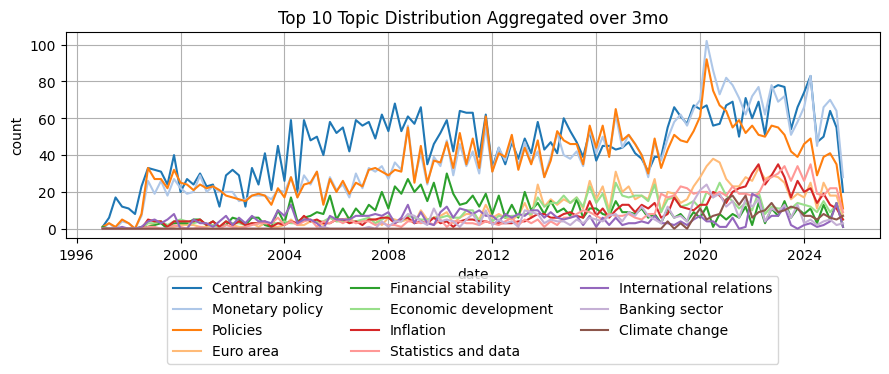

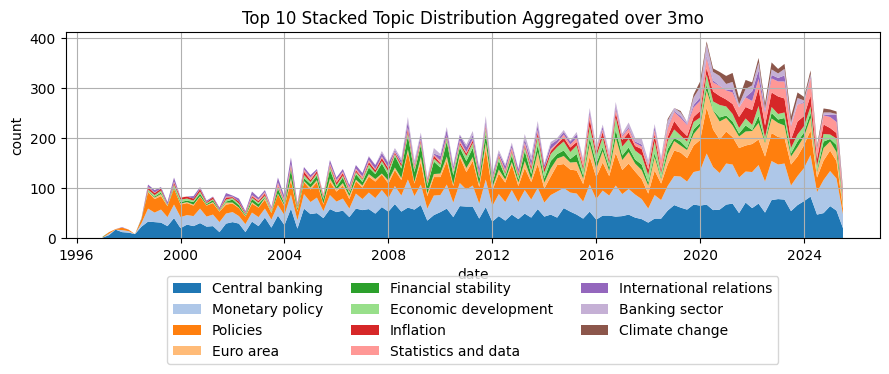

In [64]:
k = 10
top_k_topics = all_df_exp['topic_names'].value_counts().sort('count', descending=True).head(k)['topic_names'].to_list()
print(top_k_topics)
top_k_topics = top_k_topics + ['Climate change']
freq_agg = '3mo' 
plot_topics(all_df_exp, topic_col='topic_names', topics = top_k_topics, relative= False,freq = freq_agg, title = f"Top {k} Topic Distribution Aggregated over {freq_agg}")
plot_topics_stacked(all_df_exp, topic_col='topic_names', topics = top_k_topics, relative= False, freq = freq_agg, title = f"Top {k} Stacked Topic Distribution Aggregated over {freq_agg}")

C:\Users\povhi\AppData\Local\Temp\ipykernel_28128\2137815247.py:47: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)

C:\Users\povhi\AppData\Local\Temp\ipykernel_28128\2137815247.py:48: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)

C:\Users\povhi\AppData\Local\Temp\ipykernel_28128\2137815247.py:53: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



(<Figure size 900x400 with 1 Axes>,
 <Axes: title={'center': 'Distribution aggegrated over 3mo - Climate change'}, xlabel='date', ylabel='count'>)

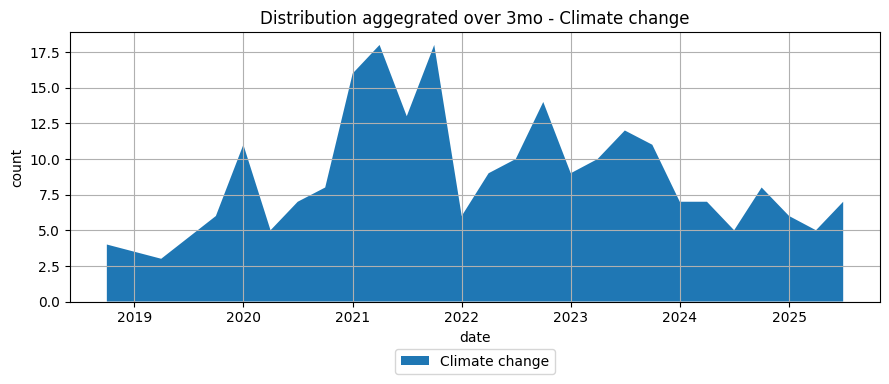

In [54]:
single_topic = "Climate change"
freq_agg = '3mo' 
plot_topics_stacked(all_df_exp, topic_col='topic_names', topics = [single_topic], relative= False, freq = freq_agg, title = f"Distribution aggegrated over {freq_agg} - {single_topic}")

In [73]:
all_df_exp_auth_exp = all_df_exp.explode("authors")

C:\Users\povhi\AppData\Local\Temp\ipykernel_28128\4194819528.py:14: DeprecationWarning:

the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.

C:\Users\povhi\AppData\Local\Temp\ipykernel_28128\4194819528.py:25: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



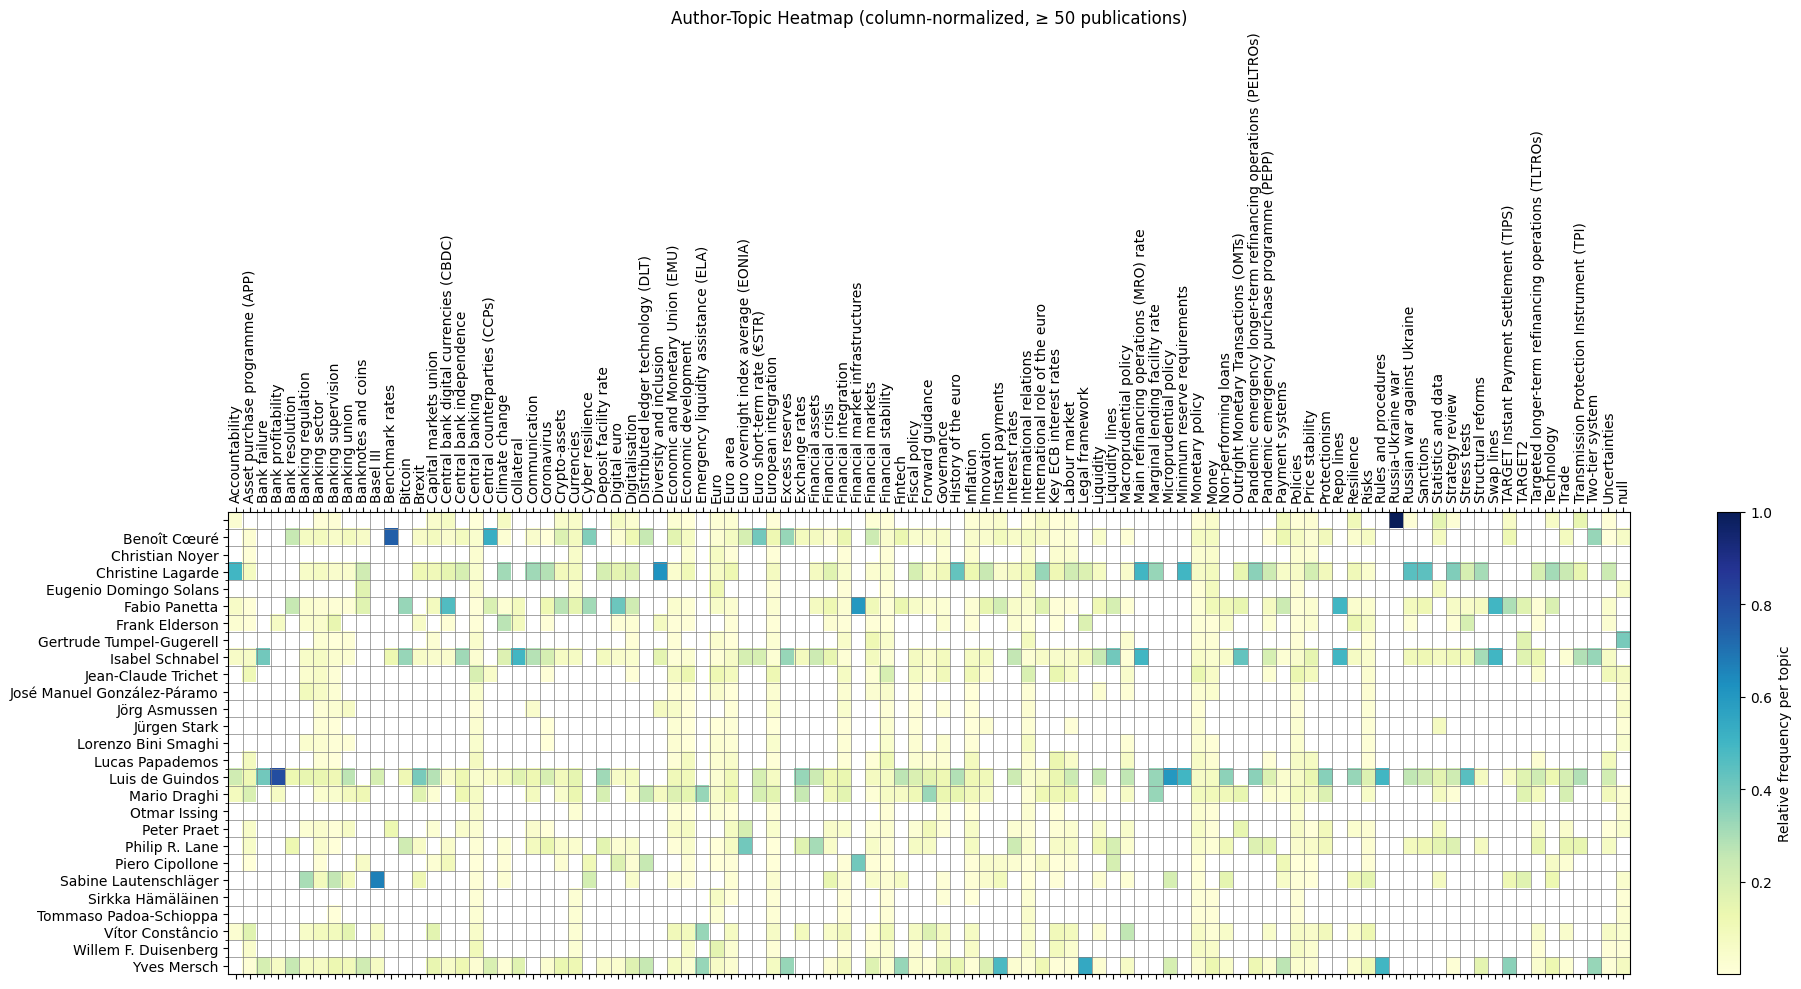

In [74]:
import polars as pl
import matplotlib.pyplot as plt

top_k = 50

author_counts = all_df_exp_auth_exp.group_by("authors").len().rename({"len": "n_pubs"})
filtered = all_df_exp_auth_exp.join(author_counts.filter(pl.col("n_pubs") >= top_k), on="authors")

counts = (
    filtered.group_by(["authors", "topic_names"])
    .len()
    .rename({"len": "count"})
)
pivoted = counts.pivot(
    values="count",
    index="authors",
    columns="topic_names",
    aggregate_function="first"
).fill_null(0)

df_pandas = pivoted.to_pandas().set_index("authors")
df_pandas = df_pandas[sorted(df_pandas.columns)].sort_index()
df_pandas = df_pandas.div(df_pandas.sum(axis=0), axis=1)

cmap = plt.cm.get_cmap("YlGnBu").copy()
cmap.set_bad(color="white")
masked = df_pandas.mask(df_pandas == 0)

fig, ax = plt.subplots(figsize=(20,10))
cax = ax.matshow(masked, cmap=cmap, aspect="auto")

ax.set_xticks(range(len(df_pandas.columns)))
ax.set_xticklabels(df_pandas.columns, rotation=90)
ax.set_yticks(range(len(df_pandas.index)))
ax.set_yticklabels(df_pandas.index)

fig.colorbar(cax, label="Relative frequency per topic")
plt.title(f"Author-Topic Heatmap (column-normalized, ≥ {top_k} publications)")

ax.set_xticks([x-0.5 for x in range(1, len(df_pandas.columns))], minor=True)
ax.set_yticks([y-0.5 for y in range(1, len(df_pandas.index))], minor=True)
ax.grid(which="minor", color="gray", linewidth=0.5)

plt.tight_layout()
plt.show()


C:\Users\povhi\AppData\Local\Temp\ipykernel_28128\3287961488.py:14: DeprecationWarning:

the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.

C:\Users\povhi\AppData\Local\Temp\ipykernel_28128\3287961488.py:25: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



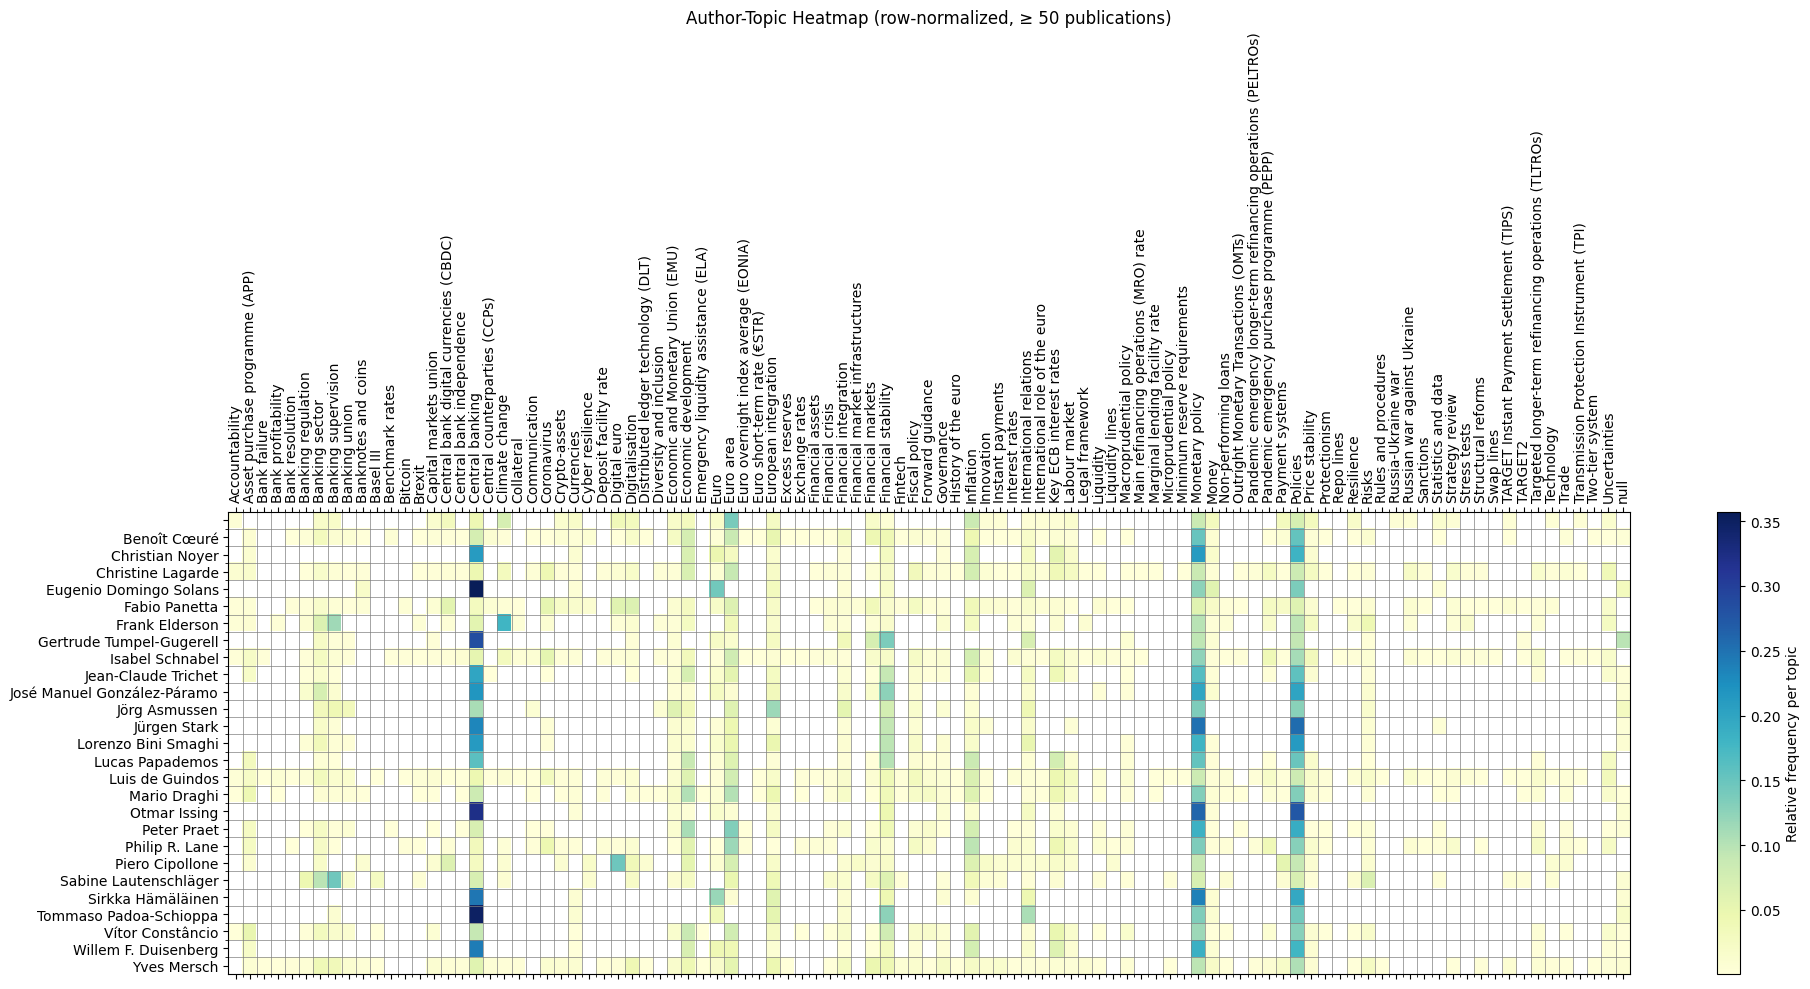

In [44]:
import polars as pl
import matplotlib.pyplot as plt

top_k = 50

author_counts = all_df_exp_auth_exp.group_by("authors").len().rename({"len": "n_pubs"})
filtered = all_df_exp_auth_exp.join(author_counts.filter(pl.col("n_pubs") >= top_k), on="authors")

counts = (
    filtered.group_by(["authors", "topic_names"])
    .len()
    .rename({"len": "count"})
)
pivoted = counts.pivot(
    values="count",
    index="authors",
    columns="topic_names",
    aggregate_function="first"
).fill_null(0)

df_pandas = pivoted.to_pandas().set_index("authors")
df_pandas = df_pandas[sorted(df_pandas.columns)].sort_index()
df_pandas = df_pandas.div(df_pandas.sum(axis=1), axis=0)

cmap = plt.cm.get_cmap("YlGnBu").copy()
cmap.set_bad(color="white")
masked = df_pandas.mask(df_pandas == 0)

fig, ax = plt.subplots(figsize=(20,10))
cax = ax.matshow(masked, cmap=cmap, aspect="auto")

ax.set_xticks(range(len(df_pandas.columns)))
ax.set_xticklabels(df_pandas.columns, rotation=90)
ax.set_yticks(range(len(df_pandas.index)))
ax.set_yticklabels(df_pandas.index)

fig.colorbar(cax, label="Relative frequency per topic")
plt.title(f"Author-Topic Heatmap (row-normalized, ≥ {top_k} publications)")

ax.set_xticks([x-0.5 for x in range(1, len(df_pandas.columns))], minor=True)
ax.set_yticks([y-0.5 for y in range(1, len(df_pandas.index))], minor=True)
ax.grid(which="minor", color="gray", linewidth=0.5)

plt.tight_layout()
plt.show()

In [59]:
all_df['id'].value_counts()['count'].max()

1

C:\Users\povhi\AppData\Local\Temp\ipykernel_28128\748276934.py:28: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



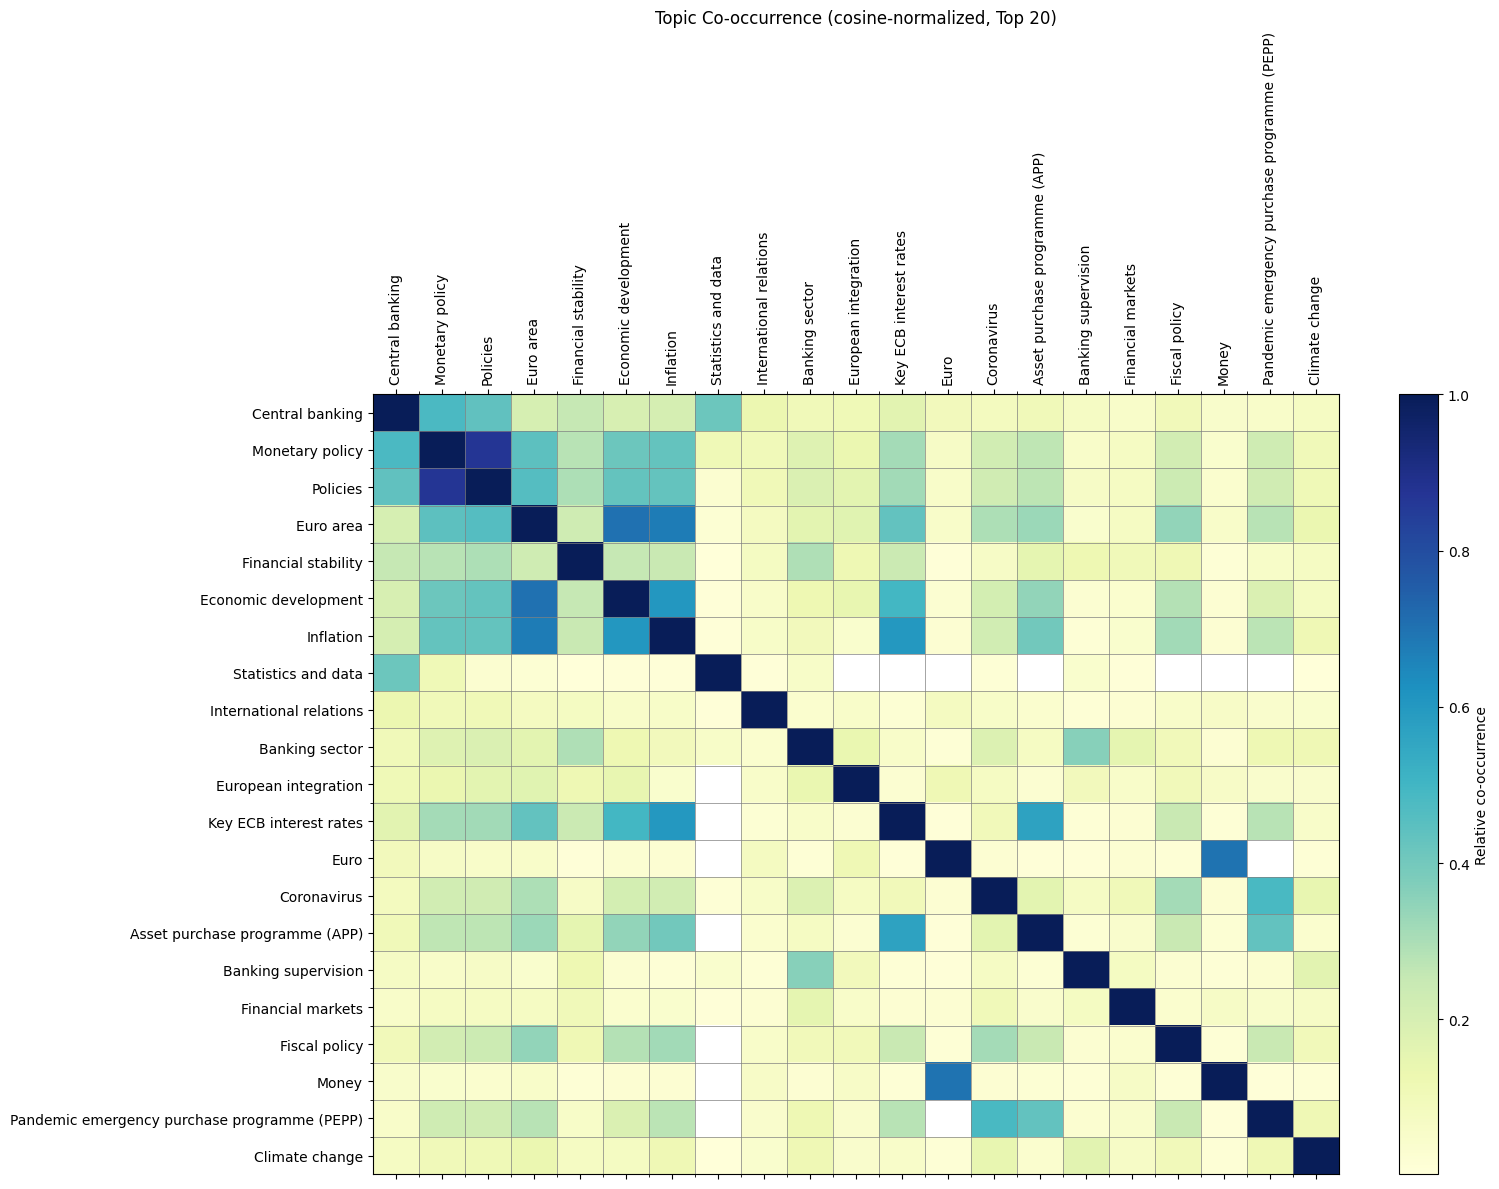

In [72]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

top_k = 20

df_idx = all_df.with_row_index("doc_id").select(["doc_id", "topic_names"])
expl = df_idx.explode("topic_names").rename({"topic_names": "topic"}).drop_nulls("topic")

top_topics = (
    expl.group_by("topic").len().rename({"len":"count"})
        .sort("count", descending=True)
        .select("topic").head(top_k).to_series().to_list()
) + ["Climate change"]

expl_top = expl.filter(pl.col("topic").is_in(top_topics)).to_pandas()
wide = pd.crosstab(expl_top["doc_id"], expl_top["topic"])
wide = wide.reindex(columns=top_topics, fill_value=0)
co = wide.T.dot(wide)
co = co.reindex(index=top_topics, columns=top_topics, fill_value=0)

d = np.diag(co.values)
norm = co.values / np.sqrt(np.outer(d, d))
norm = pd.DataFrame(norm, index=co.index, columns=co.columns)
np.fill_diagonal(norm.values, 1.0)

cmap = plt.cm.get_cmap("YlGnBu").copy()
cmap.set_bad("white")
masked = norm.mask(norm == 0)

fig, ax = plt.subplots(figsize=(16,12))
cax = ax.mathow(masked, cmap=cmap, aspect="auto") if hasattr(ax, "mathow") else ax.matshow(masked, cmap=cmap, aspect="auto")

ax.set_xticks(range(len(norm.columns)))
ax.set_xticklabels(norm.columns, rotation=90)
ax.set_yticks(range(len(norm.index)))
ax.set_yticklabels(norm.index)

fig.colorbar(cax, label="Relative co-occurrence")
plt.title(f"Topic Co-occurrence (cosine-normalized, Top {top_k})")

ax.set_xticks([x-0.5 for x in range(1, len(norm.columns))], minor=True)
ax.set_yticks([y-0.5 for y in range(1, len(norm.index))], minor=True)
ax.grid(which="minor", color="gray", linewidth=0.5)

plt.tight_layout()
plt.show()

In [79]:
all_df_exp['category_base'].value_counts()

category_base,count
str,u32
"""Convergence Report""",16
"""Balance of payments (quarterly…",88
"""Feedback on the input provided…",5
"""Economic Bulletin""",1139
"""Annual consolidated balance sh…",6
…,…
"""TARGET Services Annual Report""",2
"""Governing Council statement""",2
"""Forum on Central Banking""",1


C:\Users\povhi\AppData\Local\Temp\ipykernel_28128\1608631333.py:14: DeprecationWarning:

the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.

C:\Users\povhi\AppData\Local\Temp\ipykernel_28128\1608631333.py:25: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



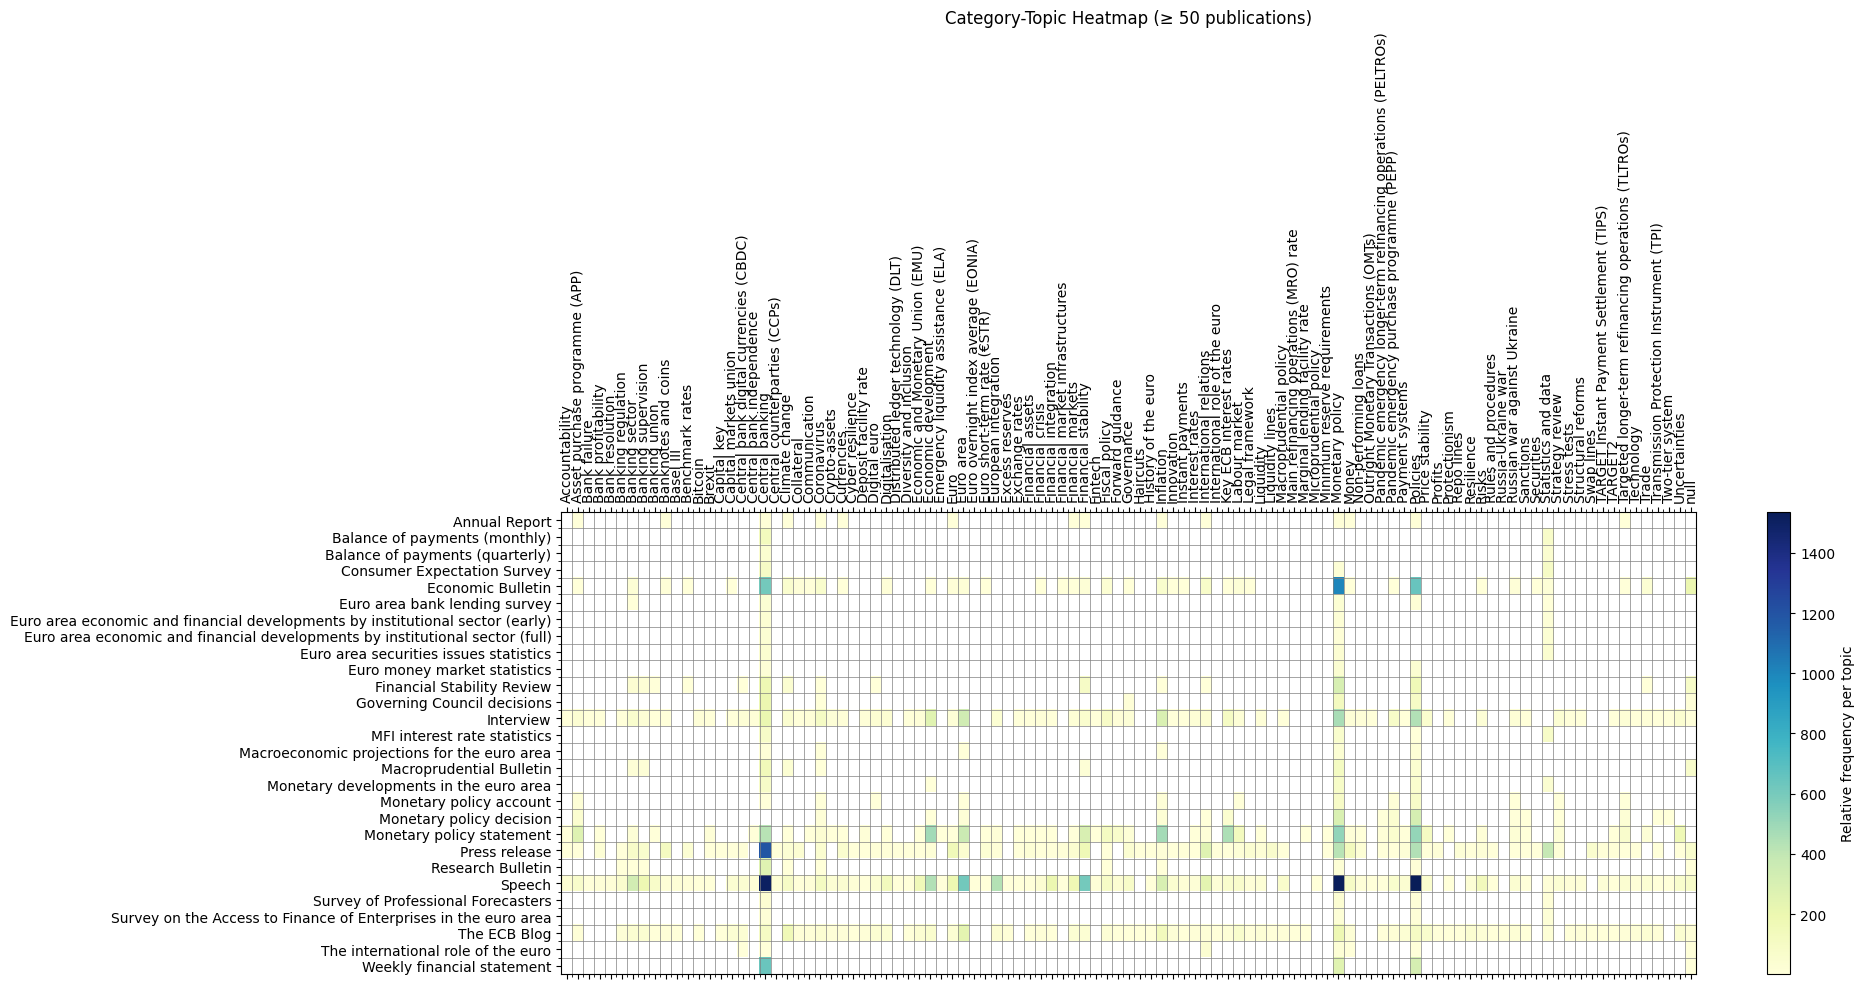

In [80]:
import polars as pl
import matplotlib.pyplot as plt

top_k = 50

author_counts = all_df_exp_auth_exp.group_by("category_base").len().rename({"len": "n_pubs"})
filtered = all_df_exp_auth_exp.join(author_counts.filter(pl.col("n_pubs") >= top_k), on="category_base")

counts = (
    filtered.group_by(["category_base", "topic_names"])
    .len()
    .rename({"len": "count"})
)
pivoted = counts.pivot(
    values="count",
    index="category_base",
    columns="topic_names",
    aggregate_function="first"
).fill_null(0)

df_pandas = pivoted.to_pandas().set_index("category_base")
df_pandas = df_pandas[sorted(df_pandas.columns)].sort_index()
# df_pandas = df_pandas.div(df_pandas.sum(axis=1), axis=0)

cmap = plt.cm.get_cmap("YlGnBu").copy()
cmap.set_bad(color="white")
masked = df_pandas.mask(df_pandas == 0)

fig, ax = plt.subplots(figsize=(20,10))
cax = ax.matshow(masked, cmap=cmap, aspect="auto")

ax.set_xticks(range(len(df_pandas.columns)))
ax.set_xticklabels(df_pandas.columns, rotation=90)
ax.set_yticks(range(len(df_pandas.index)))
ax.set_yticklabels(df_pandas.index)

fig.colorbar(cax, label="Frequency per topic")
plt.title(f"Category-Topic Heatmap (≥ {top_k} publications)")

ax.set_xticks([x-0.5 for x in range(1, len(df_pandas.columns))], minor=True)
ax.set_yticks([y-0.5 for y in range(1, len(df_pandas.index))], minor=True)
ax.grid(which="minor", color="gray", linewidth=0.5)

plt.tight_layout()
plt.show()